# 📊 Relation Extraction Evaluation Pipeline

This notebook evaluates the performance of a species interaction relation extraction model. It includes three main components:

---

## 1. 🔧 Post-Processing (Normalization)

Before evaluation, the predicted and ground truth triples are **normalized** to ensure accurate matching:

- **Species Names**:
  - Lowercased
  - Stripped of whitespace and punctuation
  - Plural 's' is optionally removed for consistency

- **Interaction Relations**:
  - Canonicalized using a pre-defined mapping
  - Synonyms like `"eats"`, `"feedsOn"` → `"preyson"`
  - Ensures different expressions of the same relation are treated equally

---

## 2. 🧮 Evaluation Metrics

The script compares the normalized predicted and ground-truth interaction triples using the following metrics:

| Metric        | Description                                             |
|---------------|---------------------------------------------------------|
| **TP**        | True Positives: correctly predicted interactions        |
| **FP**        | False Positives: incorrect predictions                  |
| **FN**        | False Negatives: missed correct interactions            |
| **Precision** | TP / (TP + FP) - how accurate the predictions are       |
| **Recall**    | TP / (TP + FN) - how many true relations were found     |
| **F1 Score**  | Harmonic mean of Precision and Recall                   |
| **Error Rate**| (FP + FN) / (TP + FP + FN) - overall mistake frequency  |

These metrics are calculated both **overall** and **per interaction category**, such as *predation*, *mutualism*, *parasitism*, etc.

---

## 3. 📉 Visualization

Two bar plots are included for interpretability:

1. **TP / FP / FN by Category**  
   Shows how the model performs in terms of correct, wrong, and missed predictions per type.

2. **Precision / Recall / F1 Score by Category**  
   Highlights strengths and weaknesses for each interaction class.

Color-coded and well-scaled to provide insight into which categories perform better or worse.

---

## 🏁 Usage

To run this script:

1. Place your **ground truth file** (JSON) and **prediction file** (JSON) in the same directory.
2. Edit the file paths:
   ```python
   GT_PATH = "SpeciesInteraction_examples_for_finetuning.json"
   PRED_PATH = "species_relationships_llama3_3_temp5_batch_5_conf7.json"


In [7]:

import json
import re
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# --- Interaction Categories ---
INTERACTION_CATEGORIES = {
    "predation": ["eats", "eatenby", "kills", "killedby", "preyson", "preyeduponby"],
    "competition": ["allelopathof", "competeswith"],
    "mutualism": ["pollinates", "pollinatedby", "mutualistof", "symbiontof", "providesnutrientsfor", "acquiresnutrientsfrom"],
    "commensalism": ["commensalistof", "epiphyteof", "hasepiphyte", "flowersvisitedby", "visitsflowersof", "dispersalvectorof", "hasdispersalvector"],
    "parasitism": ["parasiteof", "hasparasite", "hostof", "hashost", "parasitizes", "parasitoidof", "hasparasitoid", "endoparasiteof", "hasendoparasite", "pathogenof", "haspathogen", "ectoparasiteof", "hasectoparasite", "endoparasitoidof"],
    "neutral": ["ecologicallyrelatedto", "cooccurswith", "coroostswith", "interactswith", "adjacentto", "hashabitat", "createshabitatfor", "vectorof", "hasvector"]
}

# --- Synonym Mapping ---
RELATION_SYNONYMS = {
    rel.lower(): rel.lower()
    for group in INTERACTION_CATEGORIES.values()
    for rel in group
}
RELATION_SYNONYMS.update({
    "parasitizes": "parasiteof",
    "provideshabitatfor": "createshabitatfor"
})

RELATION_TO_CATEGORY = {
    rel.lower(): cat
    for cat, group in INTERACTION_CATEGORIES.items()
    for rel in group
}
RELATION_TO_CATEGORY["parasitizes"] = "parasitism"
RELATION_TO_CATEGORY["provideshabitatfor"] = "neutral"

def normalize_species_name(name):
    name = name.strip().lower()
    name = re.sub(r"[^\w\s]", "", name)
    if name.endswith("s") and len(name) > 4:
        name = name[:-1]
    return name

def normalize_relation(relation):
    rel = relation.strip().lower()
    return RELATION_SYNONYMS.get(rel, rel)

# --- Load and Normalize Data ---
def load_ground_truth(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return set(
        (normalize_species_name(i['source']), normalize_species_name(i['target']), normalize_relation(i['interaction']))
        for i in data['interactions']
    )

"""def load_predictions(path):
    with open(path, 'r') as f:
        data = json.load(f)
    pred = set()
    for doc in data:
        seen = set()  # track seen triples in this document
        for rel in doc.get("relationships", []):
            src = normalize_species_name(rel.get("source_text", ""))
            tgt = normalize_species_name(rel.get("target_text", ""))
            r = normalize_relation(rel.get("relation", ""))
            triple = (src, tgt, r)
            if src and tgt and r and triple not in seen:
                pred.add(triple)
                seen.add(triple)
    return pred"""

def load_predictions(path):
    with open(path, 'r') as f:
        data = json.load(f)
    pred = set()
    cleaned_records = []
    for doc in data:
        seen = set()  # track seen triples in this document
        for rel in doc.get("relationships", []):
            src = normalize_species_name(rel.get("source_text", ""))
            tgt = normalize_species_name(rel.get("target_text", ""))
            r = normalize_relation(rel.get("relation", ""))

            # ❌ Skip self-relations
            if src == tgt:
                continue

            triple = (src, tgt, r)

            # ✅ Skip duplicates
            if src and tgt and r and triple not in seen:
                pred.add(triple)
                seen.add(triple)
                cleaned_records.append({
                    "doc_id": doc.get("document_id", ""),
                    "source": src,
                    "target": tgt,
                    "relation": r
                })

    cleaned_records = [
        rec for rec in cleaned_records
        if (rec["source"], rec["target"], rec["relation"]) in pred
    ]
    return pred, cleaned_records


# --- Evaluation ---
def evaluate(gt, pred):
    tp = gt & pred
    fp = pred - gt
    fn = gt - pred
    return tp, fp, fn

def compute_metrics(tp, fp, fn):
    precision = len(tp) / (len(tp) + len(fp)) if tp or fp else 0.0
    recall = len(tp) / (len(tp) + len(fn)) if tp or fn else 0.0
    f1 = 2 * len(tp) / (2 * len(tp) + len(fp) + len(fn)) if tp else 0.0
    error_rate = (len(fp) + len(fn)) / (len(tp) + len(fp) + len(fn)) if (tp or fp or fn) else 0.0
    return {"TP": len(tp), "FP": len(fp), "FN": len(fn), "Precision": precision, "Recall": recall, "F1": f1, "Error Rate": error_rate}

def evaluate_by_category(tp, fp, fn):
    cat_metrics = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})
    for s, t, r in tp:
        cat = RELATION_TO_CATEGORY.get(r, "unknown")
        cat_metrics[cat]["TP"] += 1
    for s, t, r in fp:
        cat = RELATION_TO_CATEGORY.get(r, "unknown")
        cat_metrics[cat]["FP"] += 1
    for s, t, r in fn:
        cat = RELATION_TO_CATEGORY.get(r, "unknown")
        cat_metrics[cat]["FN"] += 1
    for cat, m in cat_metrics.items():
        TP, FP, FN = m["TP"], m["FP"], m["FN"]
        m["Precision"] = TP / (TP + FP) if (TP + FP) > 0 else None
        m["Recall"] = TP / (TP + FN) if (TP + FN) > 0 else None
        m["F1"] = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else None

    return cat_metrics
from rapidfuzz import fuzz

def fuzzy_match(triple, triple_set, threshold=90):
    """
    Check if a (source, target, relation) triple matches any in triple_set
    using fuzzy string matching for source and target (relation must match exactly).
    """
    src1, tgt1, rel1 = triple
    for src2, tgt2, rel2 in triple_set:
        if rel1 != rel2:
            continue
        src_score = fuzz.token_sort_ratio(src1, src2)
        tgt_score = fuzz.token_sort_ratio(tgt1, tgt2)
        if src_score >= threshold and tgt_score >= threshold:
            return True
    return False

def fuzzy_evaluate(gt_set, pred_set, threshold=10):
    """
    Evaluate predictions against ground truth using fuzzy string matching.
    Returns TP, FP, FN sets.
    """
    tp = set()
    fp = set(pred_set)
    fn = set(gt_set)

    for pred in pred_set:
        if fuzzy_match(pred, gt_set, threshold):
            tp.add(pred)
            fp.discard(pred)
            for gt in list(fn):
                if fuzzy_match(pred, {gt}, threshold):
                    fn.discard(gt)
                    break
    return tp, fp, fn


# --- Visualization ---
def plot_category_metrics(metrics_dict):
    df = pd.DataFrame(metrics_dict).T
    df[["TP", "FP", "FN"]].plot(kind="bar", figsize=(8, 4), title="TP/FP/FN by Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    df[["Precision", "Recall", "F1"]].plot(kind="bar", figsize=(8, 4), title="Precision/Recall/F1 by Category", color=["#2ca02c", "#1f77b4", "#ff7f0e"])
    plt.ylabel("Score")
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

# --- Main Runner ---
def run(PRED_PATH: str):
    GT_PATH = "./s800_results/balanced_species_interactions_long_context.json"
    gt = load_ground_truth(GT_PATH)
    pred, cleaned_records = load_predictions(PRED_PATH)
    with open(f"{PRED_PATH}_post.json", "w") as f:
        json.dump(cleaned_records, f, indent=2)

    unknowns = set(r for _, _, r in gt.union(pred) if r not in RELATION_TO_CATEGORY)
    if unknowns:
        print("⚠️ Unknown Relations Found:", unknowns)
        print("Sample unknown triples:")
        for s, t, r in list(gt.union(pred)):
            if r in unknowns:
                print(f"  - ({s}, {t}, {r})")

    tp, fp, fn = evaluate(gt, pred)

    print("=== Overall Evaluation ===")
    overall = compute_metrics(tp, fp, fn)
    for k, v in overall.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    print("\n=== Per Interaction Type ===")
    by_cat = evaluate_by_category(tp, fp, fn)
    for cat, vals in by_cat.items():
        print(f"\n[{cat.upper()}]")
        for k, v in vals.items():
            print(f"{k}: {v:.2f}" if isinstance(v, float) and v is not None else f"{k}: {v}")

    print("\n===== Fuzzy Matching")
    ftp, ffp, ffn = fuzzy_evaluate(gt, pred, threshold = 9)
    fuzzy_evaluate_overall = compute_metrics(ftp, ffp, ffn)
    for k, v in fuzzy_evaluate_overall.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    plot_category_metrics(by_cat)


## New GT and and Prompt

### LLaMA 3.3 70B 

=== Overall Evaluation ===
TP: 94
FP: 58
FN: 6
Precision: 0.6184
Recall: 0.9400
F1: 0.7460
Error Rate: 0.4051

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 17
FP: 5
FN: 4
Precision: 0.77
Recall: 0.81
F1: 0.79

[PREDATION]
TP: 15
FP: 2
FN: 2
Precision: 0.88
Recall: 0.88
F1: 0.88

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94

[MUTUALISM]
TP: 17
FP: 49
FN: 0
Precision: 0.26
Recall: 1.00
F1: 0.41

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

===== Fuzzy Matching
TP: 94
FP: 58
FN: 6
Precision: 0.6184
Recall: 0.9400
F1: 0.7460
Error Rate: 0.4051


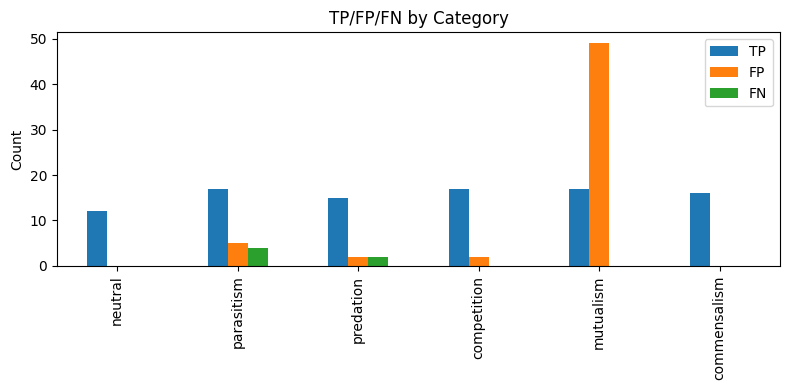

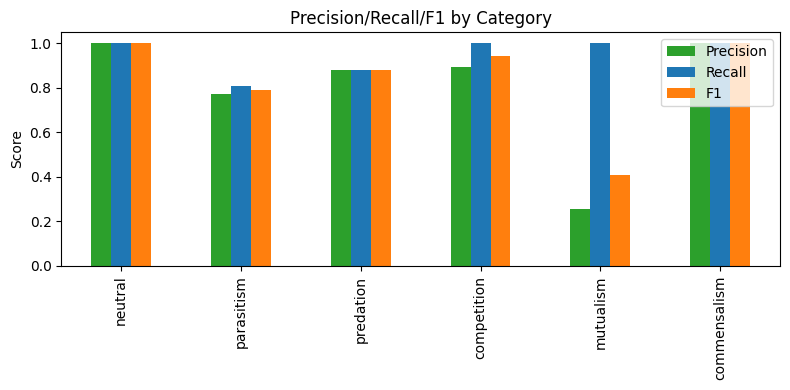

In [2]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t01_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 93
FP: 61
FN: 7
Precision: 0.6039
Recall: 0.9300
F1: 0.7323
Error Rate: 0.4224

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 51
FN: 0
Precision: 0.25
Recall: 1.00
F1: 0.40

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 14
FP: 3
FN: 3
Precision: 0.82
Recall: 0.82
F1: 0.82

[PARASITISM]
TP: 17
FP: 5
FN: 4
Precision: 0.77
Recall: 0.81
F1: 0.79

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94


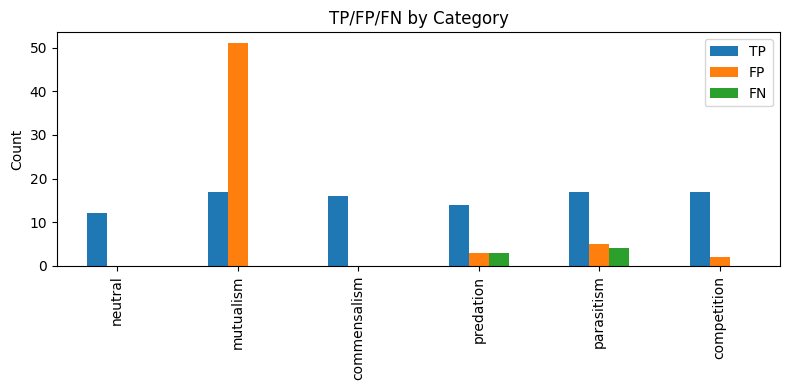

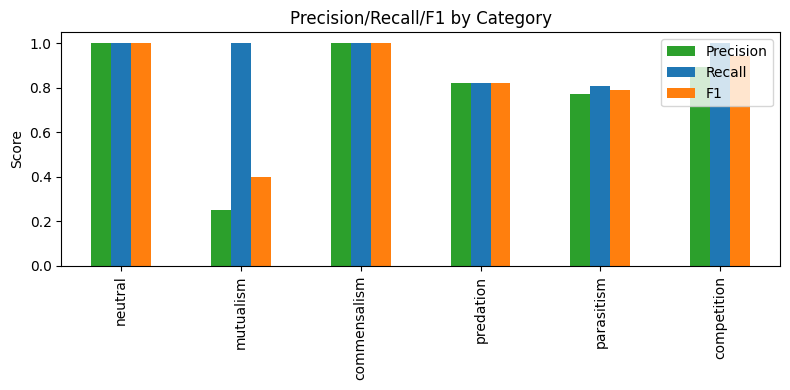

In [25]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t03_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 95
FP: 54
FN: 5
Precision: 0.6376
Recall: 0.9500
F1: 0.7631
Error Rate: 0.3831

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 47
FN: 0
Precision: 0.27
Recall: 1.00
F1: 0.42

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 16
FP: 1
FN: 1
Precision: 0.94
Recall: 0.94
F1: 0.94

[PARASITISM]
TP: 17
FP: 4
FN: 4
Precision: 0.81
Recall: 0.81
F1: 0.81

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94


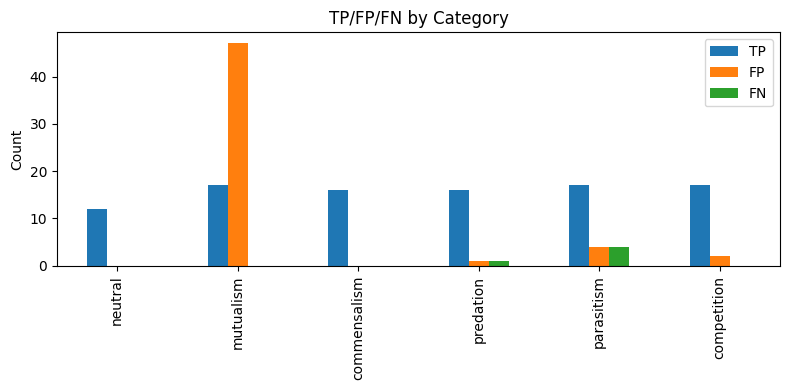

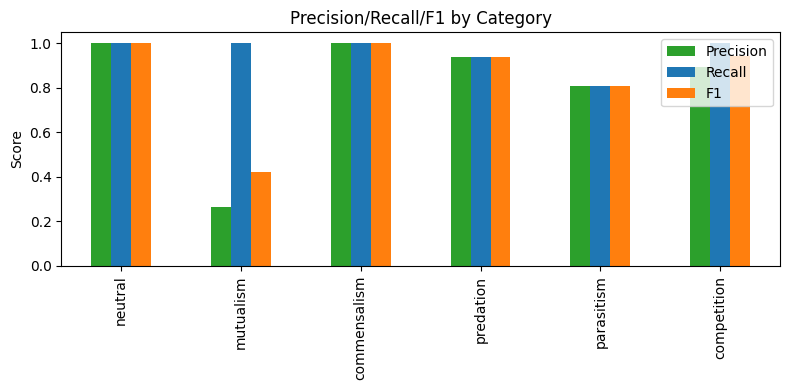

In [26]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t05_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 92
FP: 65
FN: 8
Precision: 0.5860
Recall: 0.9200
F1: 0.7160
Error Rate: 0.4424

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 51
FN: 0
Precision: 0.25
Recall: 1.00
F1: 0.40

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 13
FP: 4
FN: 4
Precision: 0.76
Recall: 0.76
F1: 0.76

[PARASITISM]
TP: 17
FP: 7
FN: 4
Precision: 0.71
Recall: 0.81
F1: 0.76

[COMPETITION]
TP: 17
FP: 3
FN: 0
Precision: 0.85
Recall: 1.00
F1: 0.92


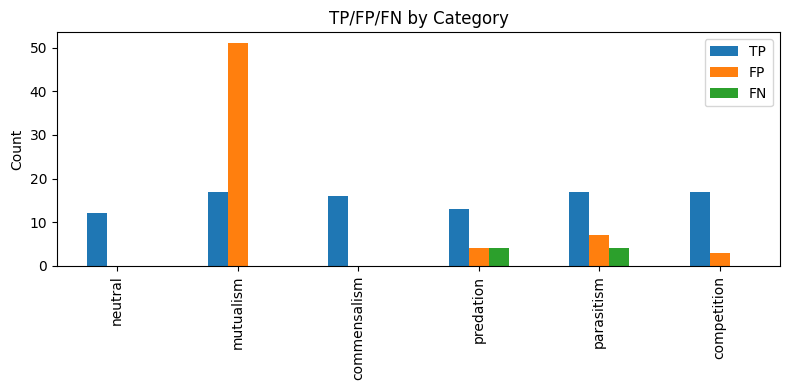

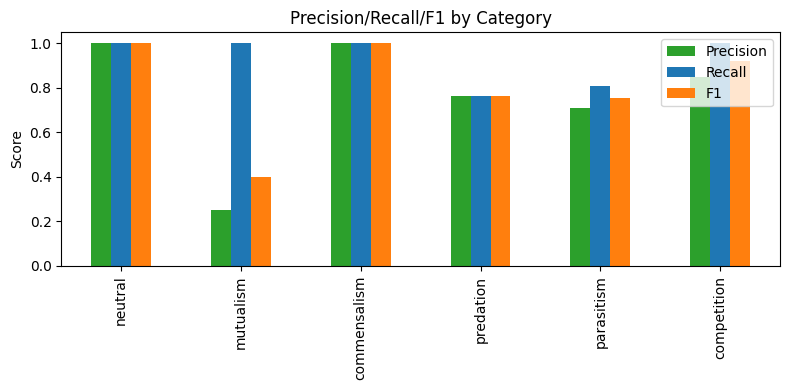

In [27]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t07_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 90
FP: 56
FN: 10
Precision: 0.6164
Recall: 0.9000
F1: 0.7317
Error Rate: 0.4231

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 43
FN: 0
Precision: 0.28
Recall: 1.00
F1: 0.44

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 11
FP: 6
FN: 6
Precision: 0.65
Recall: 0.65
F1: 0.65

[PARASITISM]
TP: 17
FP: 5
FN: 4
Precision: 0.77
Recall: 0.81
F1: 0.79

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94


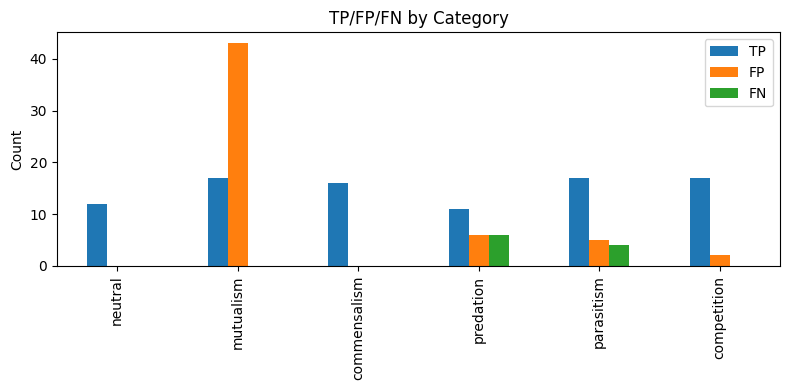

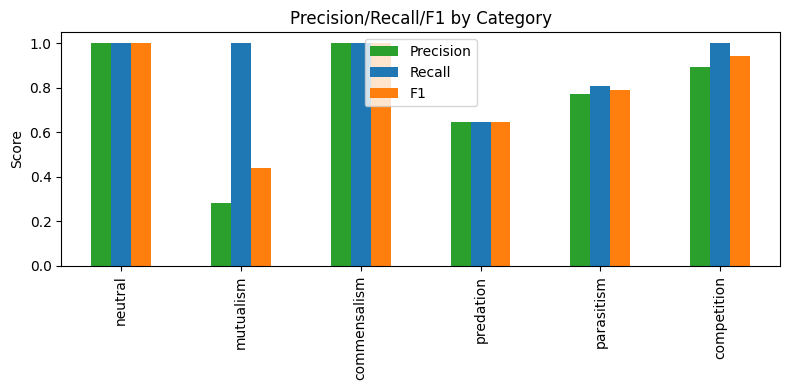

In [28]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t07_conf01_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 92
FP: 63
FN: 8
Precision: 0.5935
Recall: 0.9200
F1: 0.7216
Error Rate: 0.4356

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 51
FN: 0
Precision: 0.25
Recall: 1.00
F1: 0.40

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 12
FP: 5
FN: 5
Precision: 0.71
Recall: 0.71
F1: 0.71

[PARASITISM]
TP: 18
FP: 5
FN: 3
Precision: 0.78
Recall: 0.86
F1: 0.82

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94


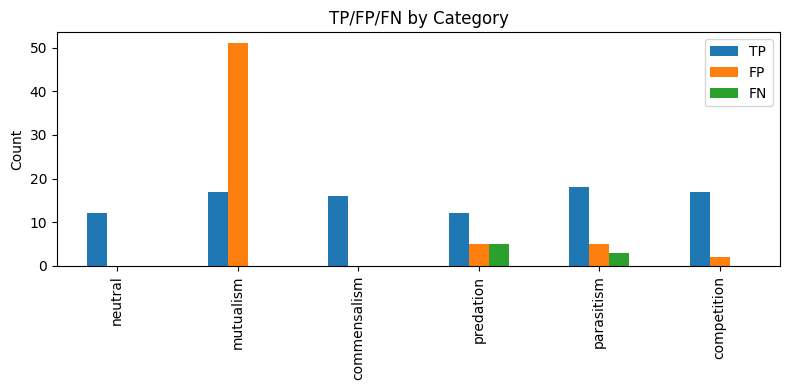

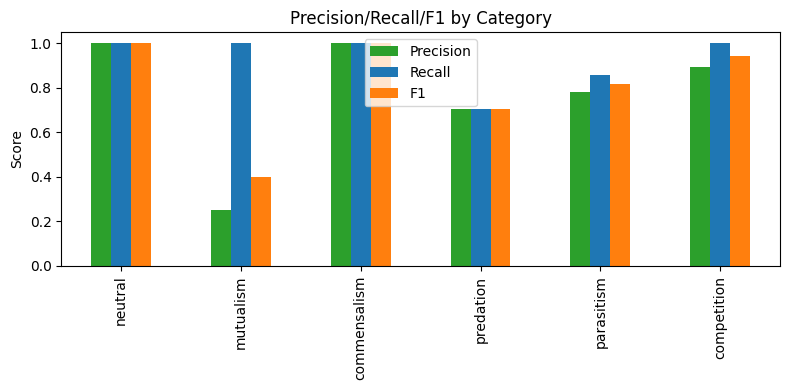

In [29]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t07_conf05_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 91
FP: 58
FN: 9
Precision: 0.6107
Recall: 0.9100
F1: 0.7309
Error Rate: 0.4241

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 47
FN: 0
Precision: 0.27
Recall: 1.00
F1: 0.42

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 12
FP: 5
FN: 5
Precision: 0.71
Recall: 0.71
F1: 0.71

[PARASITISM]
TP: 17
FP: 4
FN: 4
Precision: 0.81
Recall: 0.81
F1: 0.81

[COMPETITION]
TP: 17
FP: 2
FN: 0
Precision: 0.89
Recall: 1.00
F1: 0.94


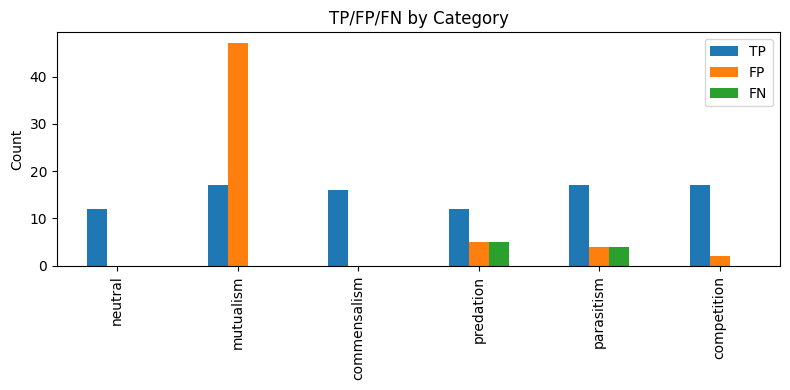

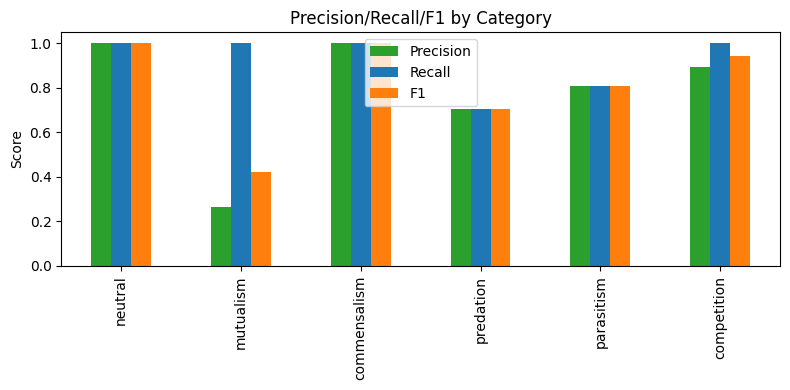

In [30]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t07_conf03_b10_final_version_of_prompt.json")

### LLaMA 4 17B Scout

=== Overall Evaluation ===
TP: 98
FP: 17
FN: 2
Precision: 0.8522
Recall: 0.9800
F1: 0.9116
Error Rate: 0.1624

=== Per Interaction Type ===

[NEUTRAL]
TP: 11
FP: 0
FN: 1
Precision: 1.00
Recall: 0.92
F1: 0.96

[MUTUALISM]
TP: 17
FP: 17
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 16
FP: 0
FN: 1
Precision: 1.00
Recall: 0.94
F1: 0.97


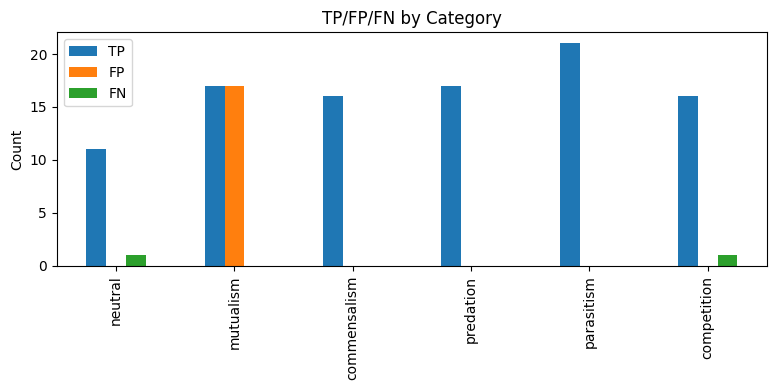

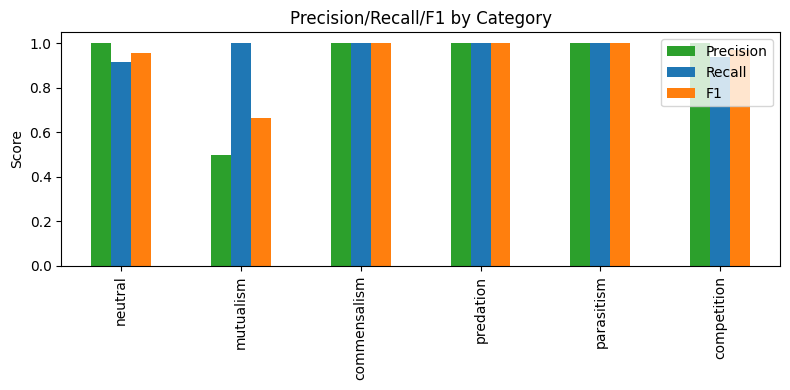

In [32]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t07_conf03_b10_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 98
FP: 17
FN: 2
Precision: 0.8522
Recall: 0.9800
F1: 0.9116
Error Rate: 0.1624

=== Per Interaction Type ===

[NEUTRAL]
TP: 10
FP: 0
FN: 2
Precision: 1.00
Recall: 0.83
F1: 0.91

[MUTUALISM]
TP: 17
FP: 17
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00


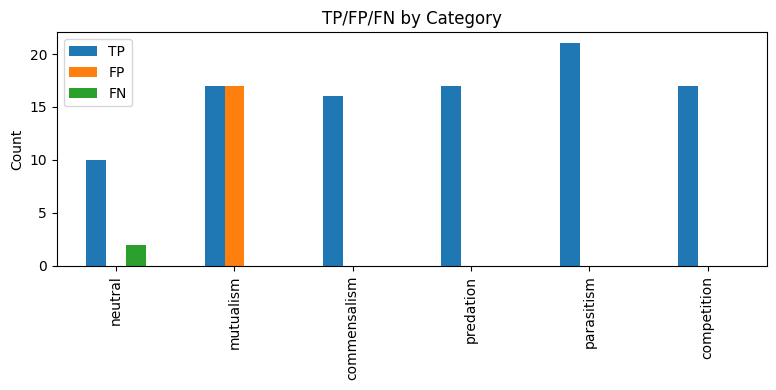

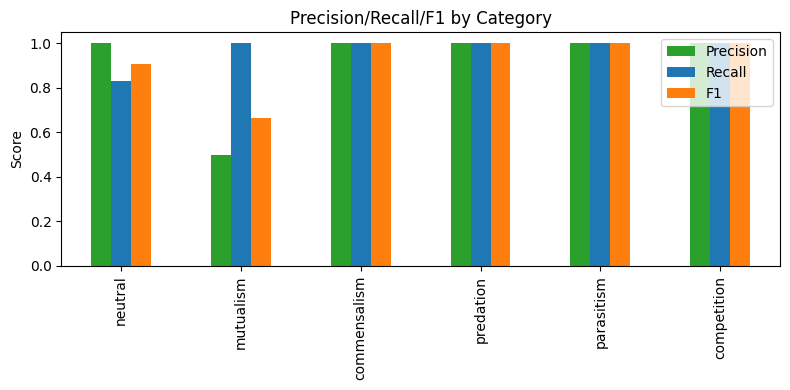

In [34]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t07_conf05_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 98
FP: 17
FN: 2
Precision: 0.8522
Recall: 0.9800
F1: 0.9116
Error Rate: 0.1624

=== Per Interaction Type ===

[NEUTRAL]
TP: 11
FP: 0
FN: 1
Precision: 1.00
Recall: 0.92
F1: 0.96

[MUTUALISM]
TP: 17
FP: 16
FN: 0
Precision: 0.52
Recall: 1.00
F1: 0.68

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 16
FP: 1
FN: 1
Precision: 0.94
Recall: 0.94
F1: 0.94

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00


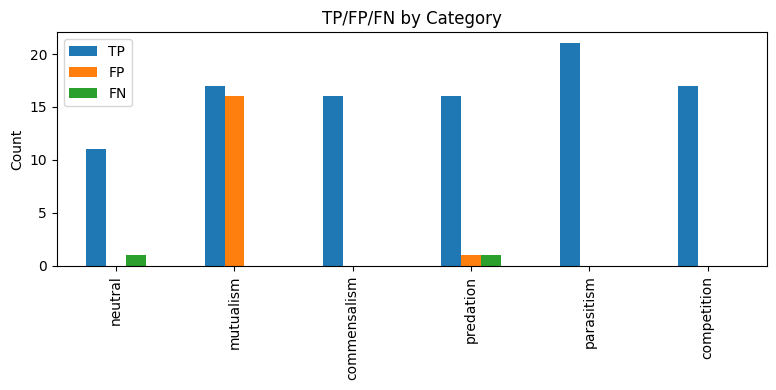

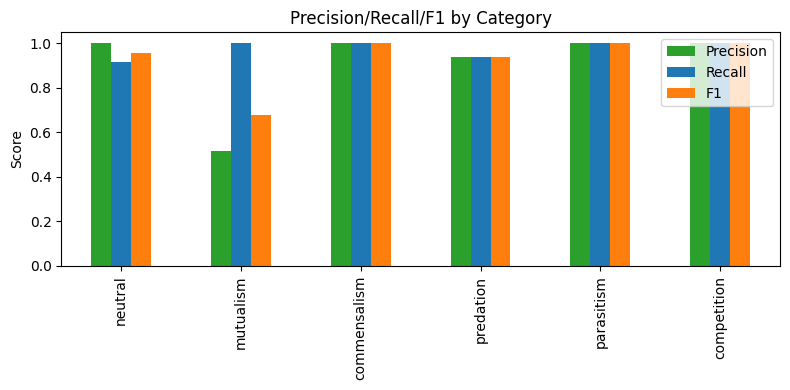

In [35]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t07_conf01_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 99
FP: 16
FN: 1
Precision: 0.8609
Recall: 0.9900
F1: 0.9209
Error Rate: 0.1466

=== Per Interaction Type ===

[NEUTRAL]
TP: 11
FP: 0
FN: 1
Precision: 1.00
Recall: 0.92
F1: 0.96

[MUTUALISM]
TP: 17
FP: 16
FN: 0
Precision: 0.52
Recall: 1.00
F1: 0.68

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00


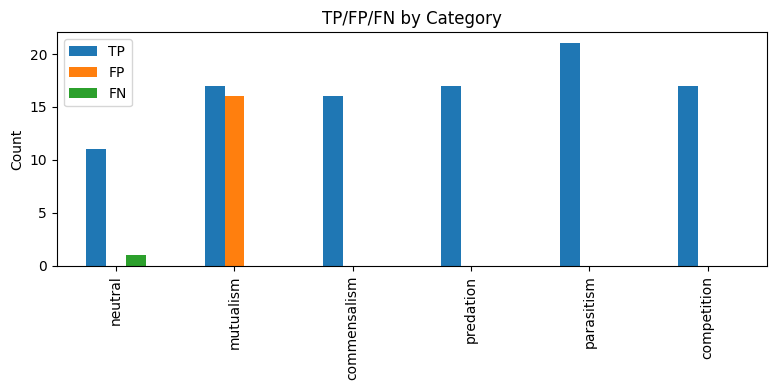

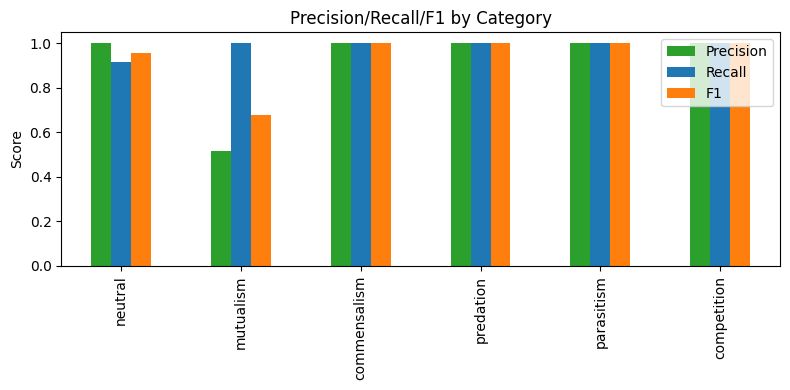

In [36]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t07_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 98
FP: 17
FN: 2
Precision: 0.8522
Recall: 0.9800
F1: 0.9116
Error Rate: 0.1624

=== Per Interaction Type ===

[NEUTRAL]
TP: 10
FP: 0
FN: 2
Precision: 1.00
Recall: 0.83
F1: 0.91

[MUTUALISM]
TP: 17
FP: 17
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00


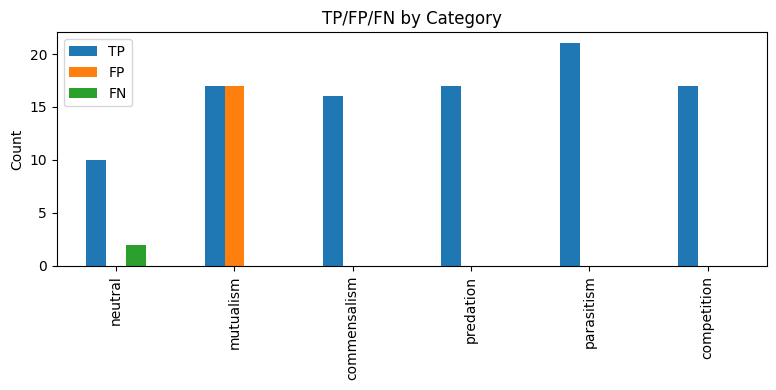

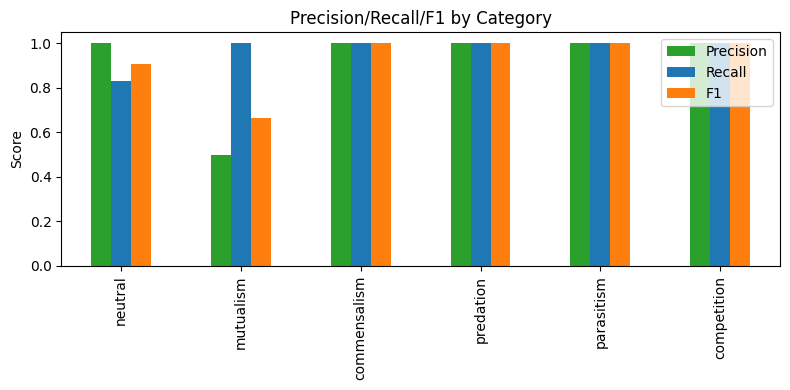

In [37]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t05_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 99
FP: 18
FN: 1
Precision: 0.8462
Recall: 0.9900
F1: 0.9124
Error Rate: 0.1610

=== Per Interaction Type ===

[NEUTRAL]
TP: 12
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 16
FP: 1
FN: 1
Precision: 0.94
Recall: 0.94
F1: 0.94

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 17
FP: 17
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

===== Fuzzy Matching
TP: 99
FP: 18
FN: 1
Precision: 0.8462
Recall: 0.9900
F1: 0.9124
Error Rate: 0.1610


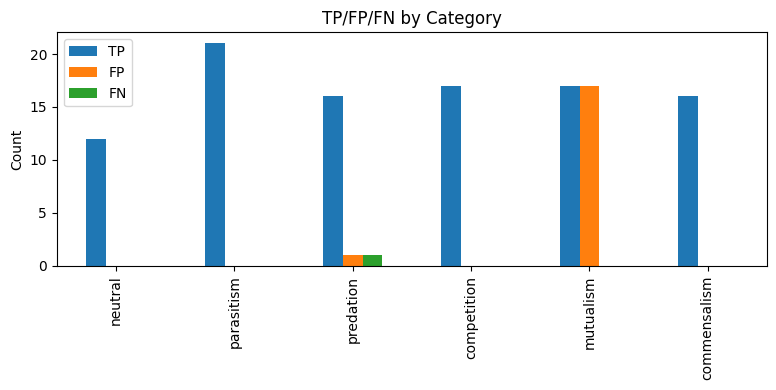

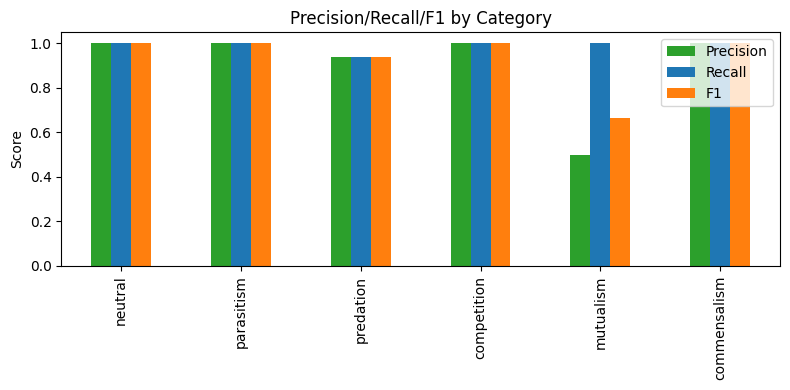

In [8]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t03_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 99
FP: 17
FN: 1
Precision: 0.8534
Recall: 0.9900
F1: 0.9167
Error Rate: 0.1538

=== Per Interaction Type ===

[NEUTRAL]
TP: 11
FP: 0
FN: 1
Precision: 1.00
Recall: 0.92
F1: 0.96

[MUTUALISM]
TP: 17
FP: 17
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[COMPETITION]
TP: 17
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00


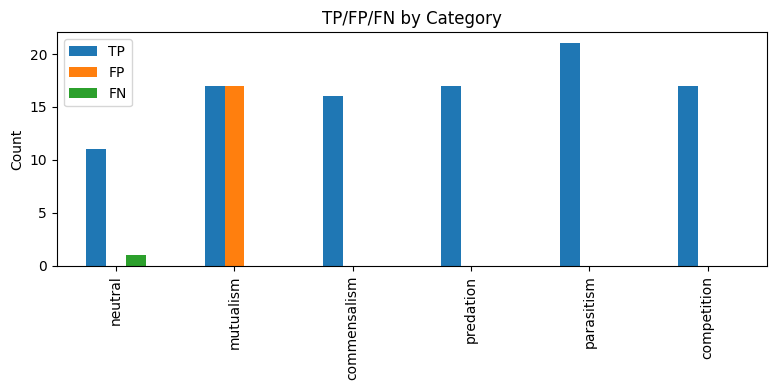

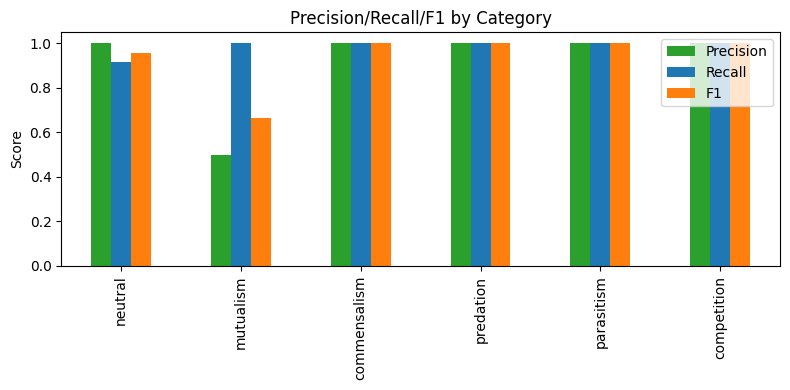

In [39]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama4_t01_conf03_b5_final_version_of_prompt.json")

### LLaMA 3.2 3B

=== Overall Evaluation ===
TP: 58
FP: 22
FN: 42
Precision: 0.7250
Recall: 0.5800
F1: 0.6444
Error Rate: 0.5246

=== Per Interaction Type ===

[NEUTRAL]
TP: 7
FP: 0
FN: 5
Precision: 1.00
Recall: 0.58
F1: 0.74

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 15
FP: 2
FN: 2
Precision: 0.88
Recall: 0.88
F1: 0.88

[PARASITISM]
TP: 20
FP: 2
FN: 1
Precision: 0.91
Recall: 0.95
F1: 0.93

[MUTUALISM]
TP: 0
FP: 12
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMPETITION]
TP: 0
FP: 6
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00


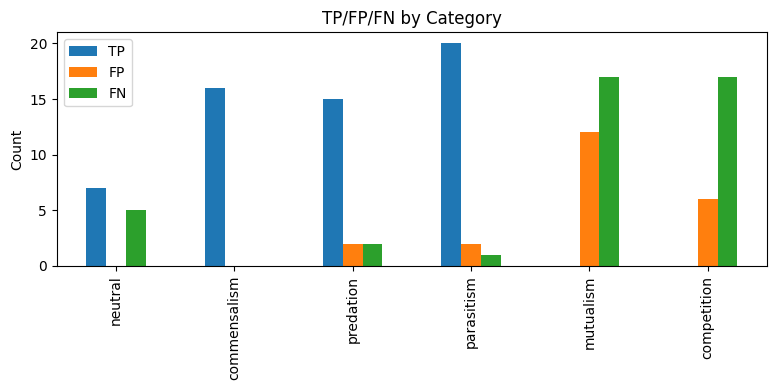

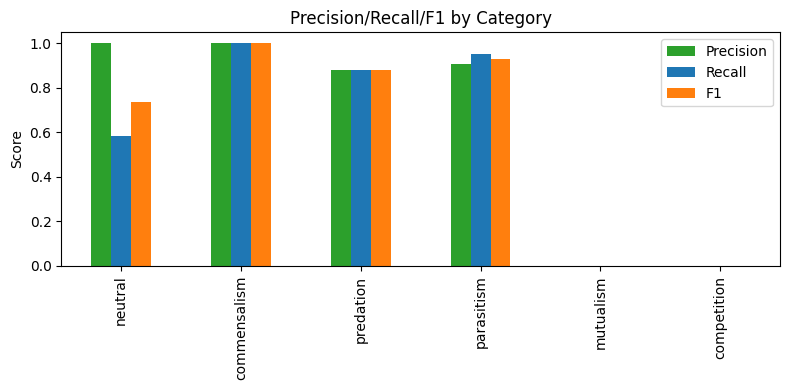

In [40]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t05_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 62
FP: 19
FN: 38
Precision: 0.7654
Recall: 0.6200
F1: 0.6851
Error Rate: 0.4790

=== Per Interaction Type ===

[NEUTRAL]
TP: 11
FP: 1
FN: 1
Precision: 0.92
Recall: 0.92
F1: 0.92

[COMMENSALISM]
TP: 16
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[PREDATION]
TP: 14
FP: 2
FN: 3
Precision: 0.88
Recall: 0.82
F1: 0.85

[PARASITISM]
TP: 21
FP: 2
FN: 0
Precision: 0.91
Recall: 1.00
F1: 0.95

[MUTUALISM]
TP: 0
FP: 11
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMPETITION]
TP: 0
FP: 3
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00


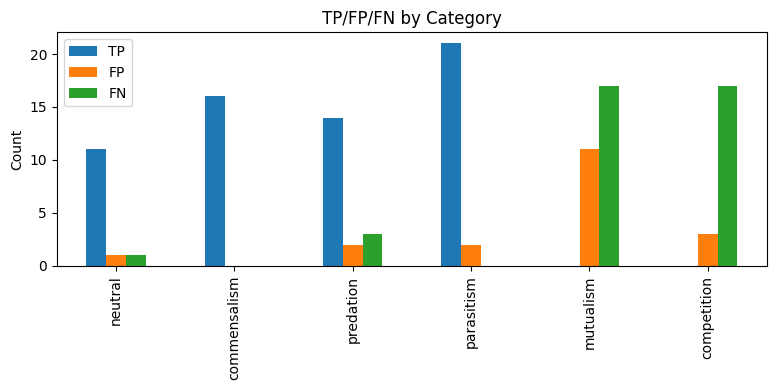

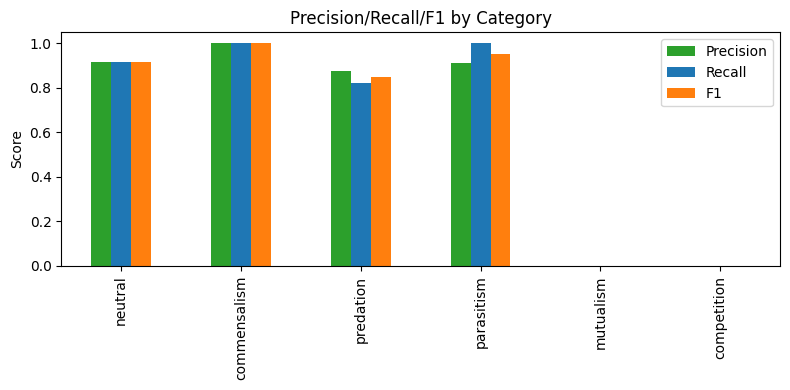

In [41]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t01_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 58
FP: 12
FN: 42
Precision: 0.8286
Recall: 0.5800
F1: 0.6824
Error Rate: 0.4821

=== Per Interaction Type ===

[NEUTRAL]
TP: 10
FP: 0
FN: 2
Precision: 1.00
Recall: 0.83
F1: 0.91

[COMMENSALISM]
TP: 14
FP: 1
FN: 2
Precision: 0.93
Recall: 0.88
F1: 0.90

[PREDATION]
TP: 13
FP: 0
FN: 4
Precision: 1.00
Recall: 0.76
F1: 0.87

[PARASITISM]
TP: 21
FP: 0
FN: 0
Precision: 1.00
Recall: 1.00
F1: 1.00

[MUTUALISM]
TP: 0
FP: 9
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMPETITION]
TP: 0
FP: 2
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00


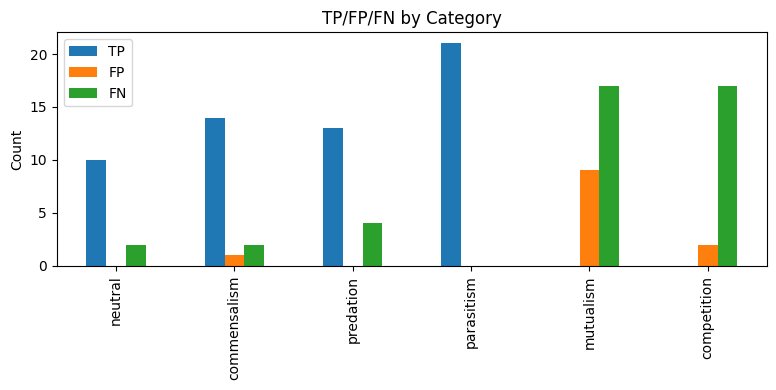

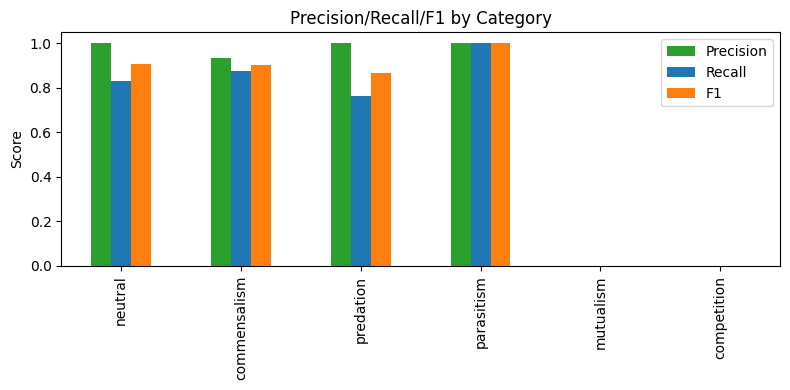

In [42]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t03_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 55
FP: 23
FN: 45
Precision: 0.7051
Recall: 0.5500
F1: 0.6180
Error Rate: 0.5528

=== Per Interaction Type ===

[NEUTRAL]
TP: 7
FP: 1
FN: 5
Precision: 0.88
Recall: 0.58
F1: 0.70

[COMMENSALISM]
TP: 14
FP: 1
FN: 2
Precision: 0.93
Recall: 0.88
F1: 0.90

[PREDATION]
TP: 14
FP: 3
FN: 3
Precision: 0.82
Recall: 0.82
F1: 0.82

[PARASITISM]
TP: 19
FP: 2
FN: 2
Precision: 0.90
Recall: 0.90
F1: 0.90

[COMPETITION]
TP: 1
FP: 6
FN: 16
Precision: 0.14
Recall: 0.06
F1: 0.08

[MUTUALISM]
TP: 0
FP: 10
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00


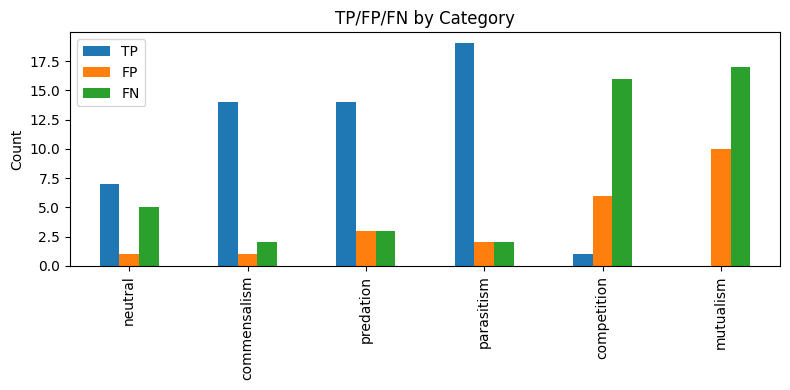

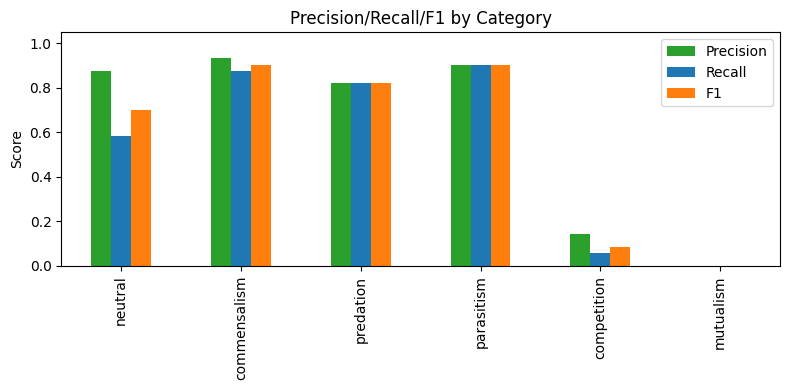

In [43]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t07_conf03_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 56
FP: 26
FN: 44
Precision: 0.6829
Recall: 0.5600
F1: 0.6154
Error Rate: 0.5556

=== Per Interaction Type ===

[NEUTRAL]
TP: 10
FP: 2
FN: 2
Precision: 0.83
Recall: 0.83
F1: 0.83

[COMMENSALISM]
TP: 14
FP: 2
FN: 2
Precision: 0.88
Recall: 0.88
F1: 0.88

[PREDATION]
TP: 12
FP: 2
FN: 5
Precision: 0.86
Recall: 0.71
F1: 0.77

[PARASITISM]
TP: 19
FP: 2
FN: 2
Precision: 0.90
Recall: 0.90
F1: 0.90

[COMPETITION]
TP: 1
FP: 5
FN: 16
Precision: 0.17
Recall: 0.06
F1: 0.09

[MUTUALISM]
TP: 0
FP: 13
FN: 17
Precision: 0.00
Recall: 0.00
F1: 0.00


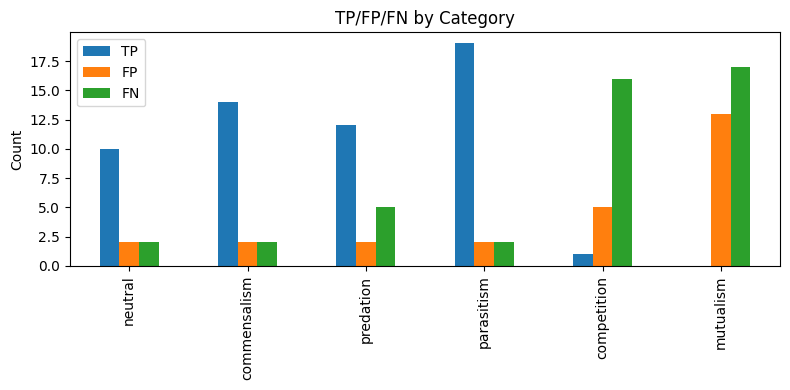

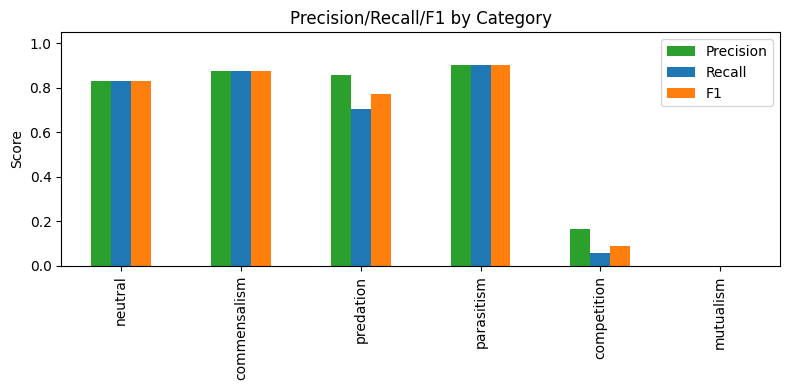

In [44]:
run( "./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t07_conf01_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 56
FP: 27
FN: 44
Precision: 0.6747
Recall: 0.5600
F1: 0.6120
Error Rate: 0.5591

=== Per Interaction Type ===

[NEUTRAL]
TP: 7
FP: 0
FN: 5
Precision: 1.00
Recall: 0.58
F1: 0.74

[COMPETITION]
TP: 4
FP: 6
FN: 13
Precision: 0.40
Recall: 0.24
F1: 0.30

[PREDATION]
TP: 14
FP: 1
FN: 3
Precision: 0.93
Recall: 0.82
F1: 0.88

[PARASITISM]
TP: 17
FP: 4
FN: 4
Precision: 0.81
Recall: 0.81
F1: 0.81

[COMMENSALISM]
TP: 13
FP: 4
FN: 3
Precision: 0.76
Recall: 0.81
F1: 0.79

[MUTUALISM]
TP: 1
FP: 12
FN: 16
Precision: 0.08
Recall: 0.06
F1: 0.07


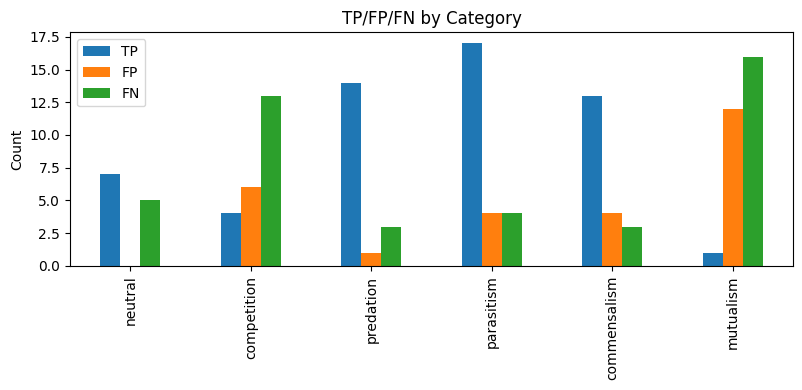

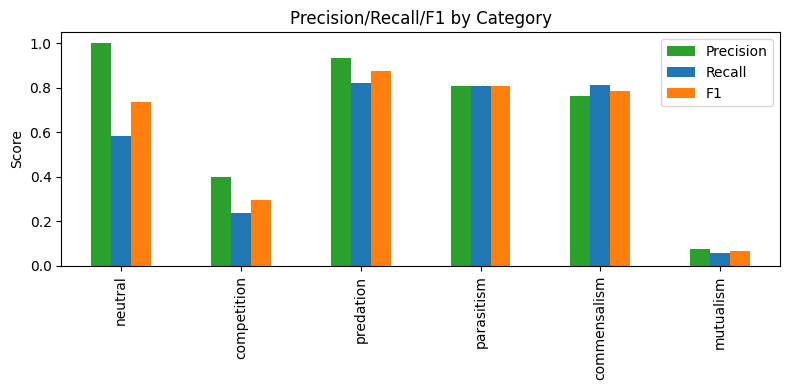

In [45]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t07_conf05_b5_final_version_of_prompt.json")

=== Overall Evaluation ===
TP: 57
FP: 22
FN: 43
Precision: 0.7215
Recall: 0.5700
F1: 0.6369
Error Rate: 0.5328

=== Per Interaction Type ===

[NEUTRAL]
TP: 8
FP: 0
FN: 4
Precision: 1.00
Recall: 0.67
F1: 0.80

[COMMENSALISM]
TP: 14
FP: 0
FN: 2
Precision: 1.00
Recall: 0.88
F1: 0.93

[PREDATION]
TP: 15
FP: 2
FN: 2
Precision: 0.88
Recall: 0.88
F1: 0.88

[PARASITISM]
TP: 17
FP: 4
FN: 4
Precision: 0.81
Recall: 0.81
F1: 0.81

[MUTUALISM]
TP: 1
FP: 10
FN: 16
Precision: 0.09
Recall: 0.06
F1: 0.07

[COMPETITION]
TP: 2
FP: 6
FN: 15
Precision: 0.25
Recall: 0.12
F1: 0.16


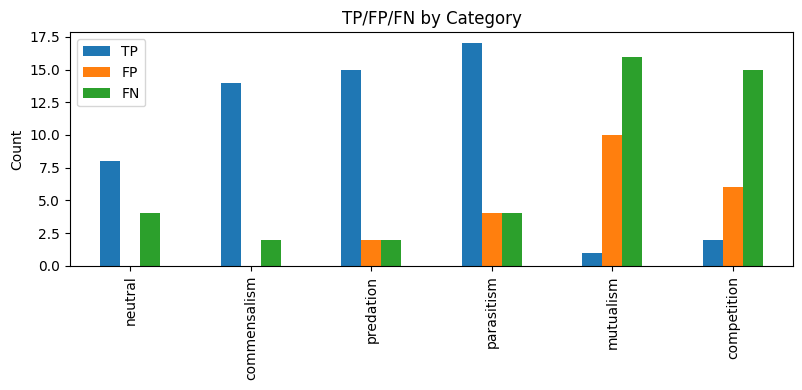

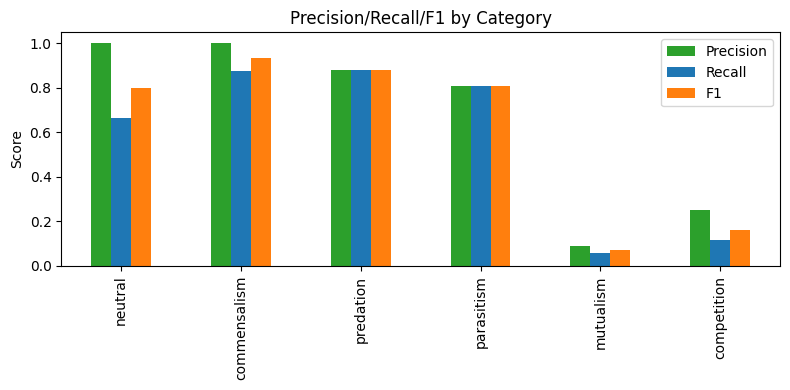

In [46]:
run("./s800_results/RE_FS_Results/speciesinteractions_llama3_2_t07_conf03_b10_final_version_of_prompt.json")

## Previous prompt and ground truth version

### LLaMA 3.3 

=== Overall Evaluation ===
TP: 23
FP: 10
FN: 35
Precision: 0.6970
Recall: 0.3966
F1: 0.5055
Error Rate: 0.6618

=== Per Interaction Type ===

[PARASITISM]
TP: 15
FP: 3
FN: 17
Precision: 0.83
Recall: 0.47
F1: 0.60

[PREDATION]
TP: 6
FP: 4
FN: 16
Precision: 0.60
Recall: 0.27
F1: 0.38

[COMPETITION]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[NEUTRAL]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


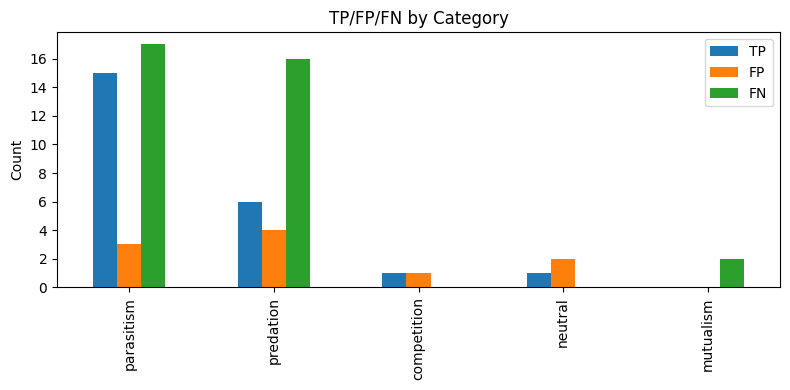

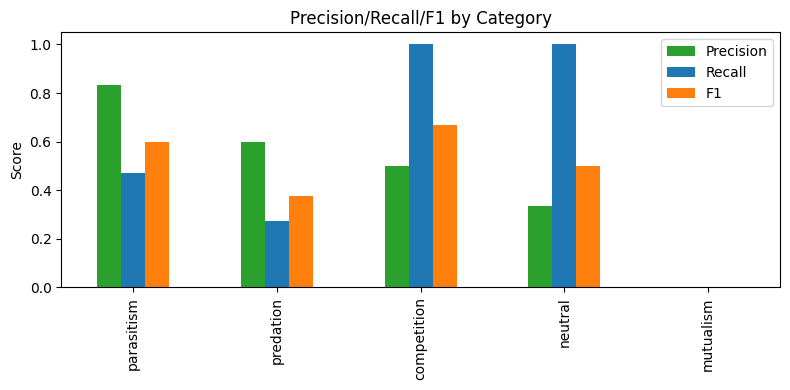

In [8]:
run("./s800_results/RE_FS_Results/species_relationships_llama3_3_temp5_batch_5_conf7.json")

=== Overall Evaluation ===
TP: 18
FP: 7
FN: 40
Precision: 0.7200
Recall: 0.3103
F1: 0.4337
Error Rate: 0.7231

=== Per Interaction Type ===

[PREDATION]
TP: 3
FP: 2
FN: 19
Precision: 0.60
Recall: 0.14
F1: 0.22

[PARASITISM]
TP: 13
FP: 3
FN: 19
Precision: 0.81
Recall: 0.41
F1: 0.54

[NEUTRAL]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[COMPETITION]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


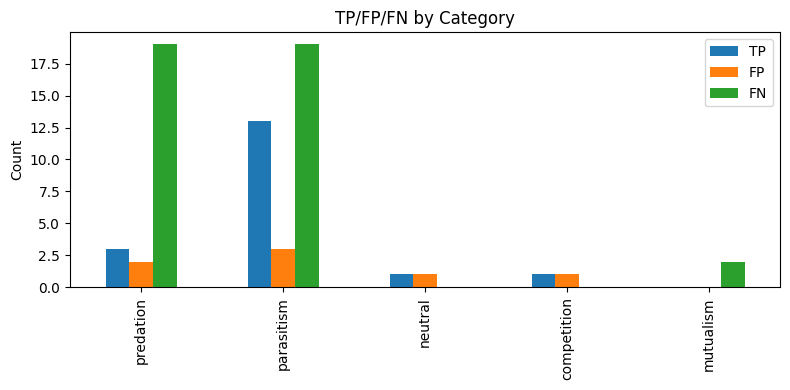

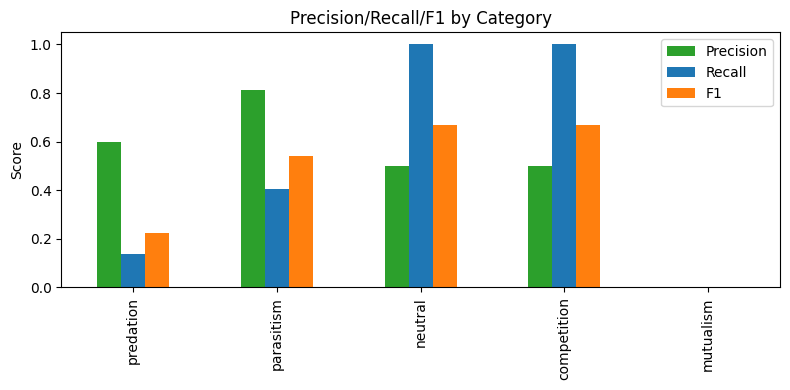

In [37]:
run("./s800_results/RE_FS_Results/species_relationships_llama3_3_temp5_batch_10_conf7.json")

=== Overall Evaluation ===
TP: 19
FP: 8
FN: 39
Precision: 0.7037
Recall: 0.3276
F1: 0.4471
Error Rate: 0.7121

=== Per Interaction Type ===

[PARASITISM]
TP: 12
FP: 3
FN: 20
Precision: 0.80
Recall: 0.38
F1: 0.51

[PREDATION]
TP: 5
FP: 2
FN: 17
Precision: 0.71
Recall: 0.23
F1: 0.34

[COMPETITION]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[NEUTRAL]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


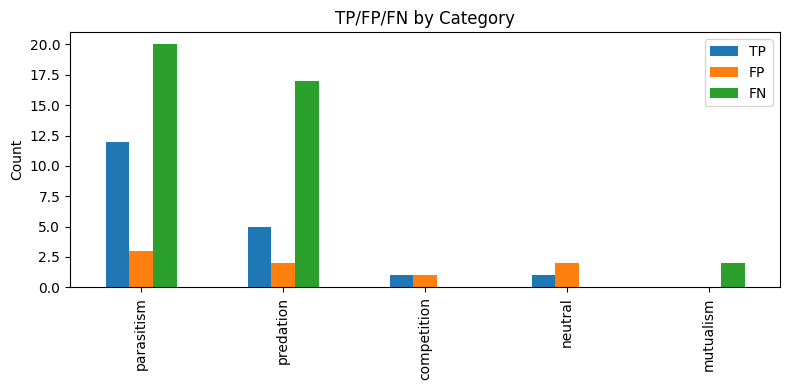

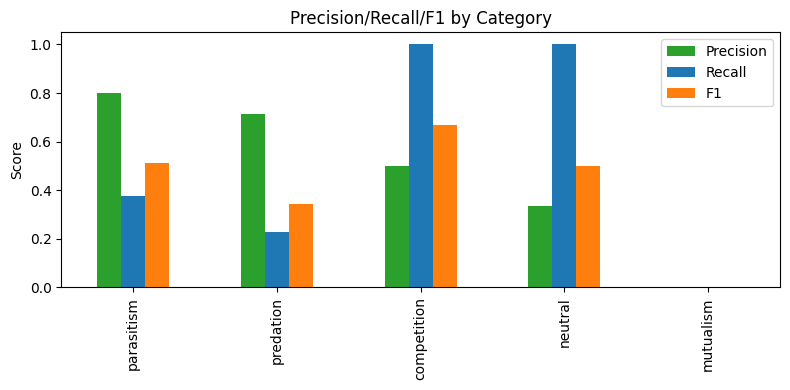

In [38]:
run("./s800_results/RE_FS_Results/species_relationships_llama3_3_temp5_batch_5_conf8.json")

=== Overall Evaluation ===
TP: 19
FP: 7
FN: 39
Precision: 0.7308
Recall: 0.3276
F1: 0.4524
Error Rate: 0.7077

=== Per Interaction Type ===

[PARASITISM]
TP: 12
FP: 3
FN: 20
Precision: 0.80
Recall: 0.38
F1: 0.51

[PREDATION]
TP: 5
FP: 1
FN: 17
Precision: 0.83
Recall: 0.23
F1: 0.36

[COMPETITION]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[NEUTRAL]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


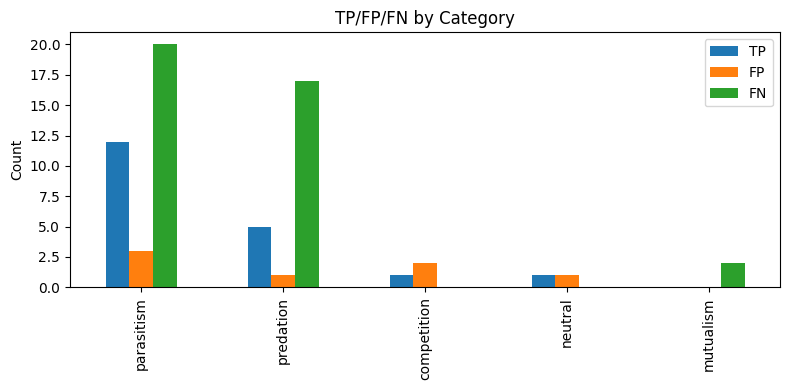

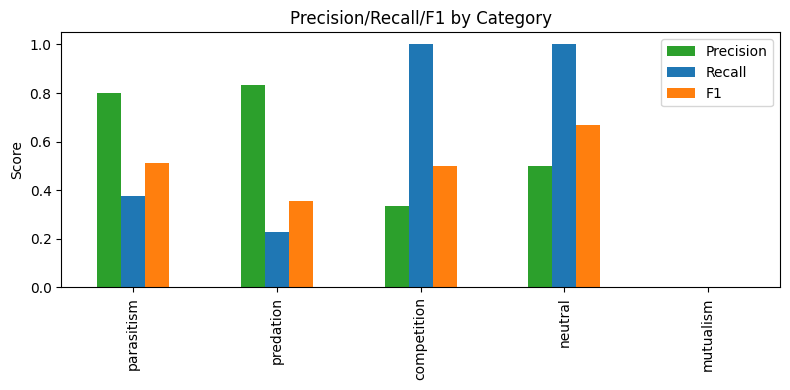

In [39]:
run("./s800_results/RE_FS_Results/species_relationships_llama3_3_temp3_batch_5_conf8.json")

=== Overall Evaluation ===
TP: 20
FP: 8
FN: 38
Precision: 0.7143
Recall: 0.3448
F1: 0.4651
Error Rate: 0.6970

=== Per Interaction Type ===

[PARASITISM]
TP: 13
FP: 4
FN: 19
Precision: 0.76
Recall: 0.41
F1: 0.53

[PREDATION]
TP: 5
FP: 2
FN: 17
Precision: 0.71
Recall: 0.23
F1: 0.34

[COMPETITION]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[NEUTRAL]
TP: 1
FP: 1
FN: 0
Precision: 0.50
Recall: 1.00
F1: 0.67

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


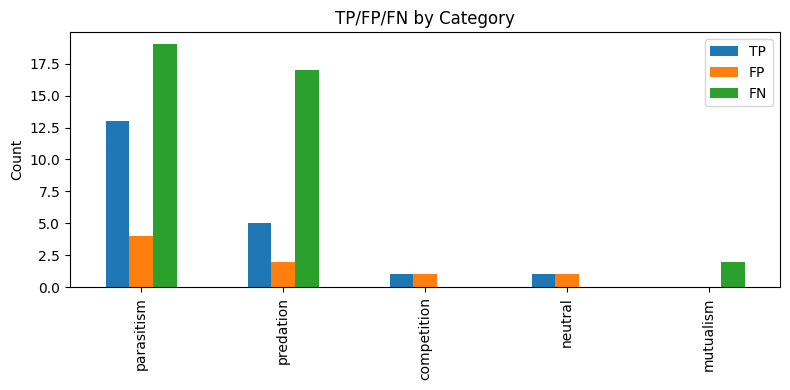

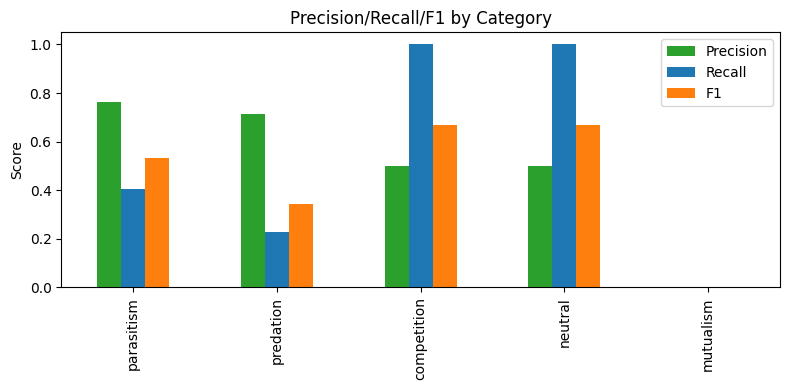

In [42]:
run("./s800_results/RE_FS_Results/species_relationships_llama3_3_temp1_batch_5_conf8.json")

### LLaMA 4

=== Overall Evaluation ===
TP: 20
FP: 11
FN: 38
Precision: 0.6452
Recall: 0.3448
F1: 0.4494
Error Rate: 0.7101

=== Per Interaction Type ===

[PREDATION]
TP: 4
FP: 1
FN: 18
Precision: 0.80
Recall: 0.18
F1: 0.30

[PARASITISM]
TP: 15
FP: 5
FN: 17
Precision: 0.75
Recall: 0.47
F1: 0.58

[COMPETITION]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[NEUTRAL]
TP: 0
FP: 1
FN: 1
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMMENSALISM]
TP: 0
FP: 2
FN: 0
Precision: 0.00
Recall: None
F1: 0.00

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


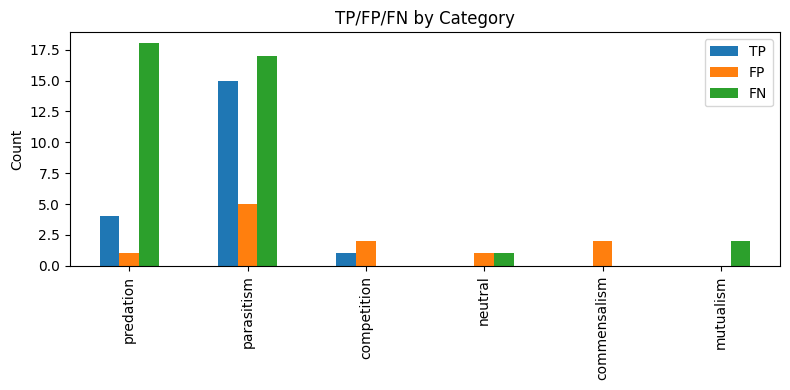

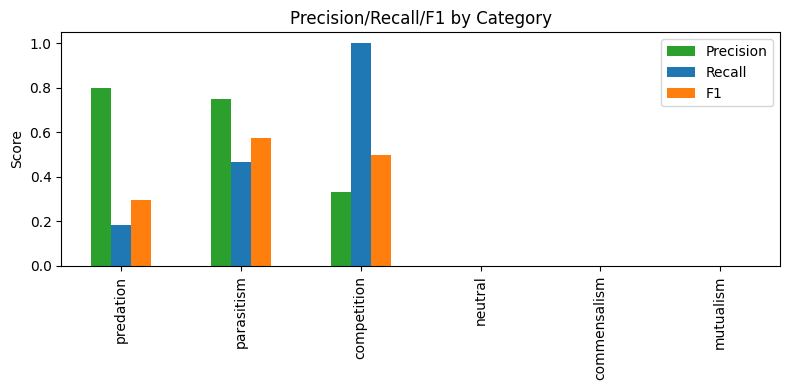

In [45]:
run("./s800_results/RE_FS_Results/species_relationships_llama4_temp1_batch_5_conf8.json")

=== Overall Evaluation ===
TP: 20
FP: 11
FN: 38
Precision: 0.6452
Recall: 0.3448
F1: 0.4494
Error Rate: 0.7101

=== Per Interaction Type ===

[PREDATION]
TP: 4
FP: 1
FN: 18
Precision: 0.80
Recall: 0.18
F1: 0.30

[PARASITISM]
TP: 15
FP: 5
FN: 17
Precision: 0.75
Recall: 0.47
F1: 0.58

[COMPETITION]
TP: 1
FP: 4
FN: 0
Precision: 0.20
Recall: 1.00
F1: 0.33

[NEUTRAL]
TP: 0
FP: 1
FN: 1
Precision: 0.00
Recall: 0.00
F1: 0.00

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


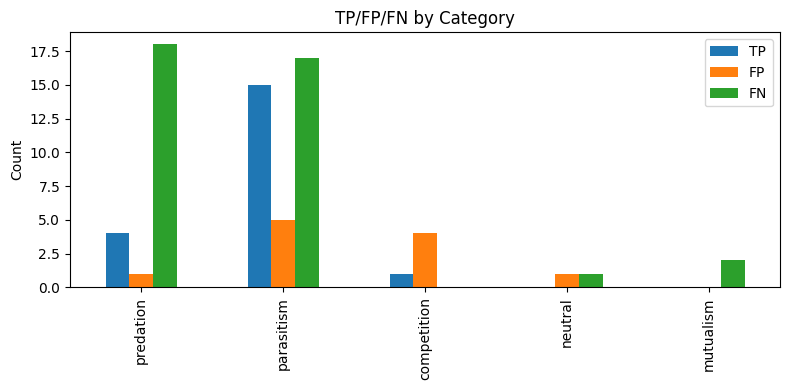

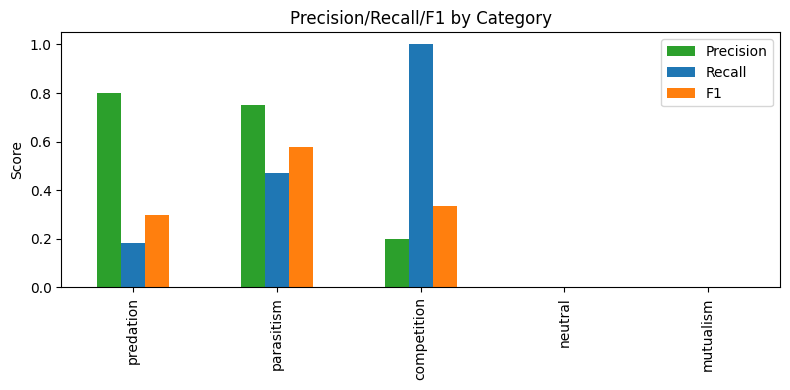

In [46]:
run("./s800_results/RE_FS_Results/species_relationships_llama4_temp3_batch_5_conf7.json")

=== Overall Evaluation ===
TP: 19
FP: 12
FN: 39
Precision: 0.6129
Recall: 0.3276
F1: 0.4270
Error Rate: 0.7286

=== Per Interaction Type ===

[PARASITISM]
TP: 15
FP: 5
FN: 17
Precision: 0.75
Recall: 0.47
F1: 0.58

[PREDATION]
TP: 3
FP: 1
FN: 19
Precision: 0.75
Recall: 0.14
F1: 0.23

[COMPETITION]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[NEUTRAL]
TP: 0
FP: 3
FN: 1
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMMENSALISM]
TP: 0
FP: 1
FN: 0
Precision: 0.00
Recall: None
F1: 0.00

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


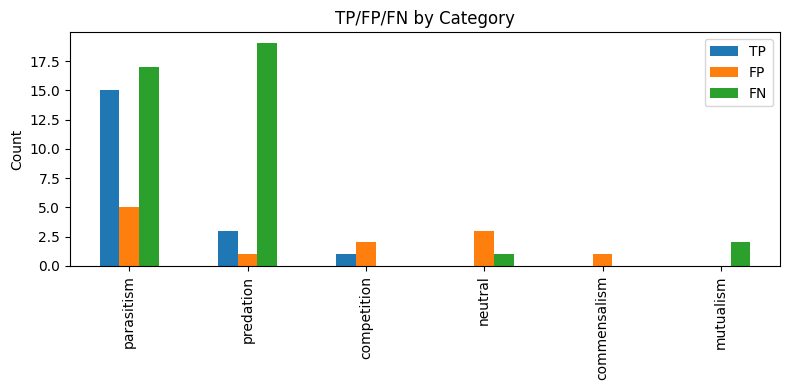

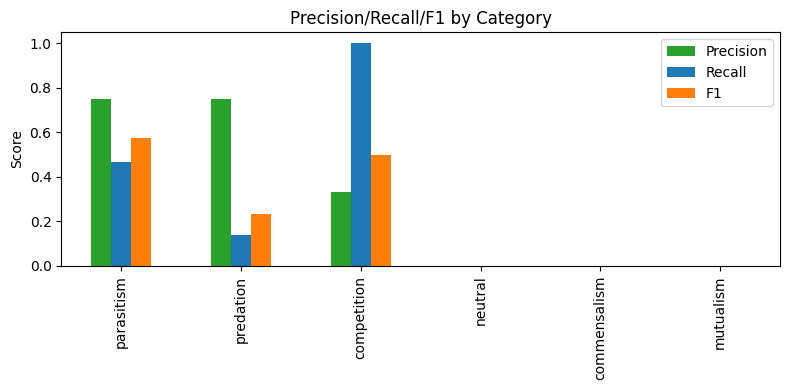

In [47]:
run("./s800_results/RE_FS_Results/species_relationships_llama4_temp3_batch_10_conf7.json")

=== Overall Evaluation ===
TP: 17
FP: 10
FN: 41
Precision: 0.6296
Recall: 0.2931
F1: 0.4000
Error Rate: 0.7500

=== Per Interaction Type ===

[PARASITISM]
TP: 13
FP: 4
FN: 19
Precision: 0.76
Recall: 0.41
F1: 0.53

[PREDATION]
TP: 3
FP: 1
FN: 19
Precision: 0.75
Recall: 0.14
F1: 0.23

[COMPETITION]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[NEUTRAL]
TP: 0
FP: 1
FN: 1
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMMENSALISM]
TP: 0
FP: 2
FN: 0
Precision: 0.00
Recall: None
F1: 0.00

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


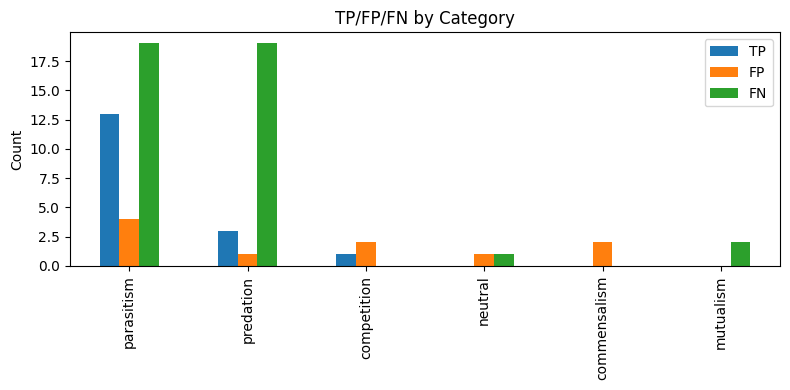

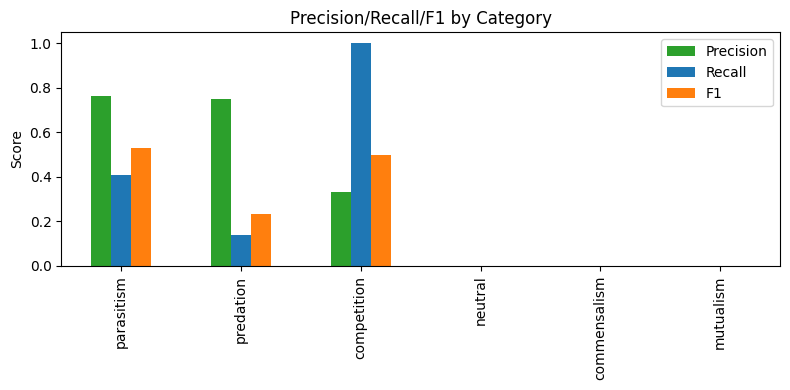

In [48]:
run("./s800_results/RE_FS_Results/species_relationships_llama4_temp5_batch_10_conf5.json")

=== Overall Evaluation ===
TP: 19
FP: 12
FN: 39
Precision: 0.6129
Recall: 0.3276
F1: 0.4270
Error Rate: 0.7286

=== Per Interaction Type ===

[PARASITISM]
TP: 15
FP: 6
FN: 17
Precision: 0.71
Recall: 0.47
F1: 0.57

[PREDATION]
TP: 3
FP: 1
FN: 19
Precision: 0.75
Recall: 0.14
F1: 0.23

[COMPETITION]
TP: 1
FP: 2
FN: 0
Precision: 0.33
Recall: 1.00
F1: 0.50

[NEUTRAL]
TP: 0
FP: 2
FN: 1
Precision: 0.00
Recall: 0.00
F1: 0.00

[COMMENSALISM]
TP: 0
FP: 1
FN: 0
Precision: 0.00
Recall: None
F1: 0.00

[MUTUALISM]
TP: 0
FP: 0
FN: 2
Precision: None
Recall: 0.00
F1: 0.00


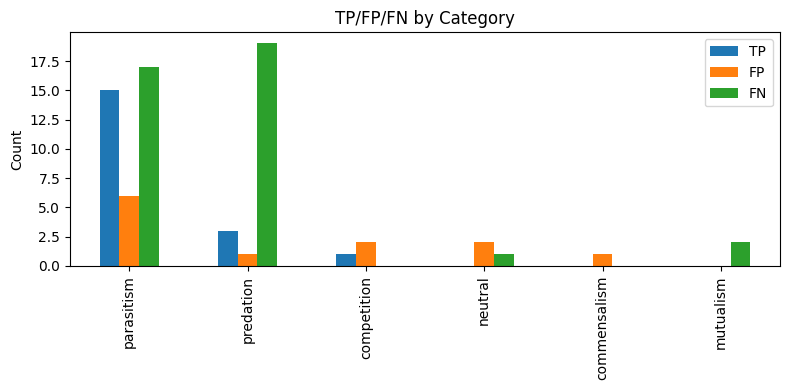

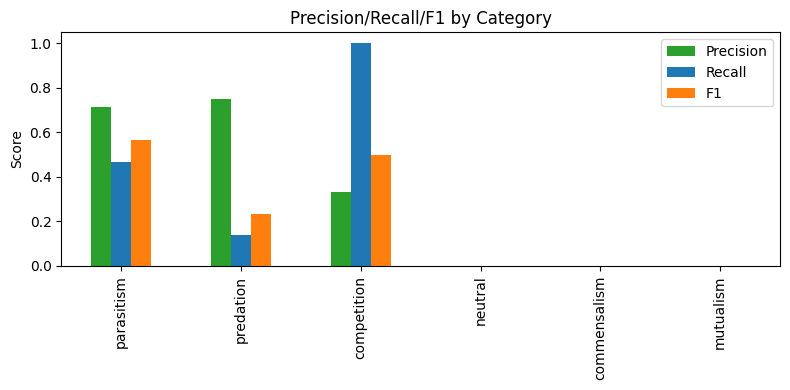

In [52]:
run("./s800_results/RE_FS_Results/species_relationships_llama4_temp5_batch_5_conf7.json")

### LLaMA 3.2

⚠️ Unknown Relations Found: {'hasparasiteof', 'has', 'hosts', 'selects', 'hasparasitoidof', 'utilizes'}
Sample unknown triples:
  - (elephant, colophospermum mopane, utilizes)
  - (metaphycus luteolu, metaphycus luteolu, hasparasitoidof)
  - (loxigilla nocti, plasmodium spp, hosts)
  - (metaphycus luteolu, metaphycus luteolu, hasparasiteof)
  - (tischeria ekebladella, phyllonorycter specie, hasparasitoidof)
  - (loxigilla nocti, haemoproteus spp, hosts)
  - (tiaris bicolor, plasmodium spp, hosts)
  - (elephant, colophospermum mopane, selects)
  - (tiaris bicolor, haemoproteus spp, hosts)
  - (phyllonorycter specie, tischeria ekebladella, hasparasitoidof)
  - (coereba flaveola, haemoproteus spp, hosts)
  - (coereba flaveola, plasmodium spp, hosts)
  - (elephant, colophospermum mopane, has)
  - (phyllonorycter specie, phyllonorycter specie, hasparasitoidof)
  - (parasitoid, phyllonorycter specie, hasparasitoidof)
=== Overall Evaluation ===
TP: 13
FP: 136
FN: 45
Precision: 0.0872
Recall: 

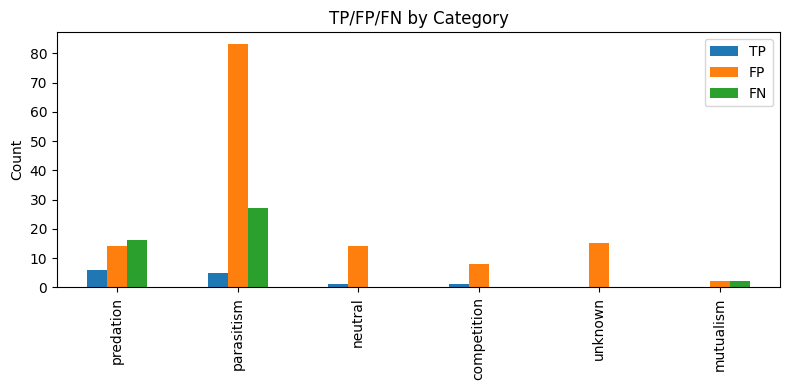

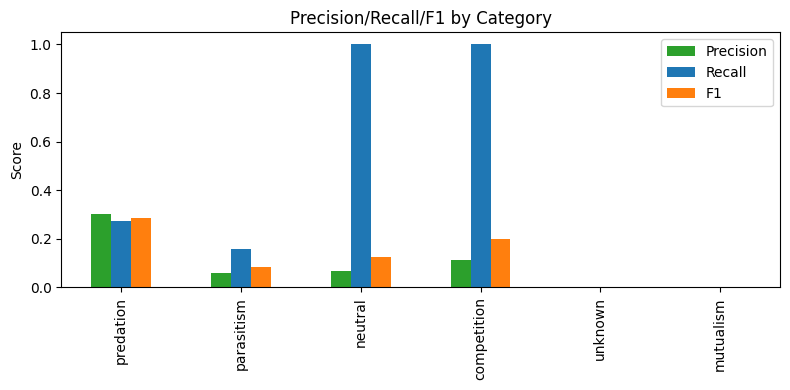

In [53]:
run("./s800_results/RE_FS_Results/species_relationships_llama32_temp5_batch_5_conf7.json")

## Knowledge Graph of the Result

In [4]:
# Install pyvis if not already installed
try:
    from pyvis.network import Network
except ImportError:
    import sys
    !{sys.executable} -m pip install pyvis
    from pyvis.network import Network
import networkx as nx
import json

# Load processed relationships
output_file_processed = "./s800_results/RE_FS_Results/speciesinteractions_llama3_3_t05_conf03_b5_final_version_of_prompt.json"

with open(output_file_processed, 'r') as f:
    data = json.load(f)

# Build the graph
G = nx.MultiDiGraph()
import matplotlib.colors as mcolors
import random

# Assign a color to each relation type
relation_types = set()
for doc in data:
    for rel in doc.get('relationships', []):
        relation_types.add(rel['relation'])
color_palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
random.shuffle(color_palette)
relation2color = {rel: color_palette[i % len(color_palette)] for i, rel in enumerate(sorted(relation_types))}

# Add nodes and edges
for doc in data:
    for rel in doc.get('relationships', []):
        src = rel['source_text']
        tgt = rel['target_text']
        label = rel['relation']
        conf = rel.get('confidence', 0)
        G.add_node(src, title=src)
        G.add_node(tgt, title=tgt)
        G.add_edge(src, tgt, label=label, color=relation2color[label], title=f"{label} (conf: {conf})")

# Create pyvis network
net = Network(height='800px', width='100%', bgcolor='#222222', font_color='white', notebook=True, directed=True, cdn_resources='in_line')
net.from_nx(G)

# Set edge colors and labels
for e in net.edges:
    rel = e['label']
    e['color'] = relation2color.get(rel, '#cccccc')
    e['title'] = rel
    e['width'] = 2

# Set node options for beauty
for n in net.nodes:
    n['size'] = 15
    n['color'] = '#1f78b4'
    n['font'] = {'size': 18, 'color': 'white'}

# Add legend for relation types
legend_html = '<div style="padding:10px; background:#222; color:white; font-size:16px;">'
legend_html += '<b>Relation Types:</b><br>'
for rel, color in relation2color.items():
    legend_html += f'<span style="color:{color};">&#9632;</span> {rel} &nbsp; '
legend_html += '</div>'

# Save and show
net.show_buttons(filter_=['physics'])
net.save_graph('species_knowledge_graph.html')
from IPython.display import display, HTML

# Display legend and graph
display(HTML(legend_html))
display(HTML(filename='species_knowledge_graph.html'))
print('Knowledge graph saved as species_knowledge_graph.html')

Knowledge graph saved as species_knowledge_graph.html
